In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from dynamics_env.dynamics_env import Dynamics
from tqdm import tqdm
import matplotlib.pyplot as plt
from dynamics_env.galaxy_models import PointSource
from scipy.integrate import solve_ivp

In [2]:
episode_length = 2048
init_params = [0.48813504, 2.15189366, 1.02763376, 2.69299098, 4.58071204, 8.75364678]
memory_size = 1e4
lookahead_options = 4
device = torch.device('cuda' if torch.cuda.is_available and False else 'cpu')
seed = 0
weights_directory = 'runs/Dynamics-v0__straight_accs__0_weights/'
lookahead_steps = 4
gamma = 0.98
M = 10

In [3]:
source = PointSource(M)
def get_equations(t, w):
    x, y, z, vx, vy, vz = w
    ax, ay, az = source.get_acceleration(np.array([x, y, z]))
    return [vx, vy, vz, ax.item(), ay.item(), az.item()]
test_orbit = solve_ivp(get_equations, t_span=(0, 100), y0=init_params, t_eval=np.linspace(0, 100, 1000)).y[:]

def denorm_state(state, env):
    return state*env.high

Text(0.5, 0.92, '3D Orbit')

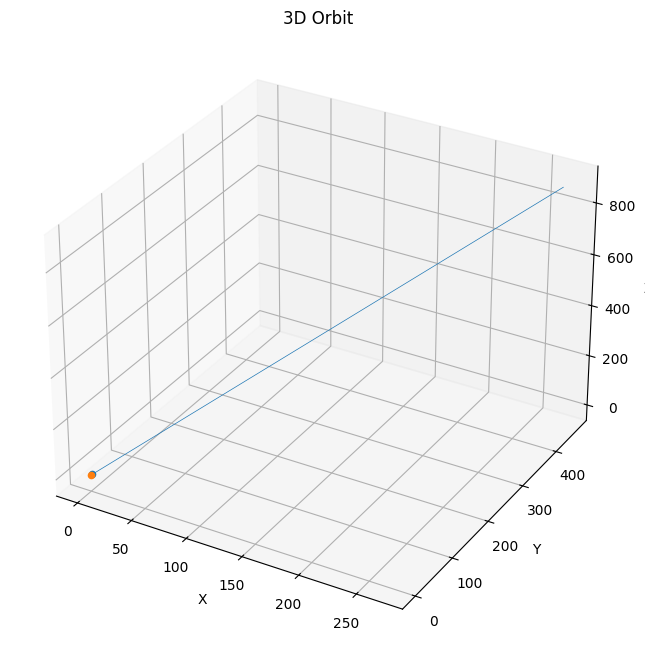

In [4]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(test_orbit[0], test_orbit[1], test_orbit[2], lw=0.5)
ax1.scatter(init_params[0], init_params[1], init_params[2], label='Trajectory start')
ax1.scatter(0, 0, 0, label='Source')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Orbit')

In [5]:
def make_env(gym_id, seed):
    def thunk():
        # env = gym.make(gym_id, hyperparameters={
        #     'galaxy_model_kwargs_list':[{'M':10}]
        # })
        env = Dynamics(hyperparameters={
            'galaxy_model_kwargs_list':[{'M':M}],
            'seed':seed,
        })
        env.action_space.seed(seed)
        env.observation_space.seed(seed)
        return env
    return thunk

In [6]:
env = make_env(None, seed=seed)()
env.reset(init_params)
init_params, reward, _, _, info = env.step(np.zeros((6)), delta=1e-8)
orbit = solve_ivp(get_equations, t_span=(0, 1000), y0=init_params, t_eval=np.linspace(0, 100, 1000))
init_params_delta = init_params + np.random.normal(scale=1e-8, size=len(init_params))
orbit_delta = solve_ivp(get_equations, t_span=(0, 1000), y0=init_params_delta, t_eval=np.linspace(0, 100, 1000))
orbit_dists = np.linalg.norm(orbit.y - orbit_delta.y, axis=0)
log_orbit_dists = np.log(orbit_dists + 1e-8)
fit_coeffs = np.polyfit(orbit.t, log_orbit_dists, 1)

[ENV] Using cpu
[ENV] Seed set to 0


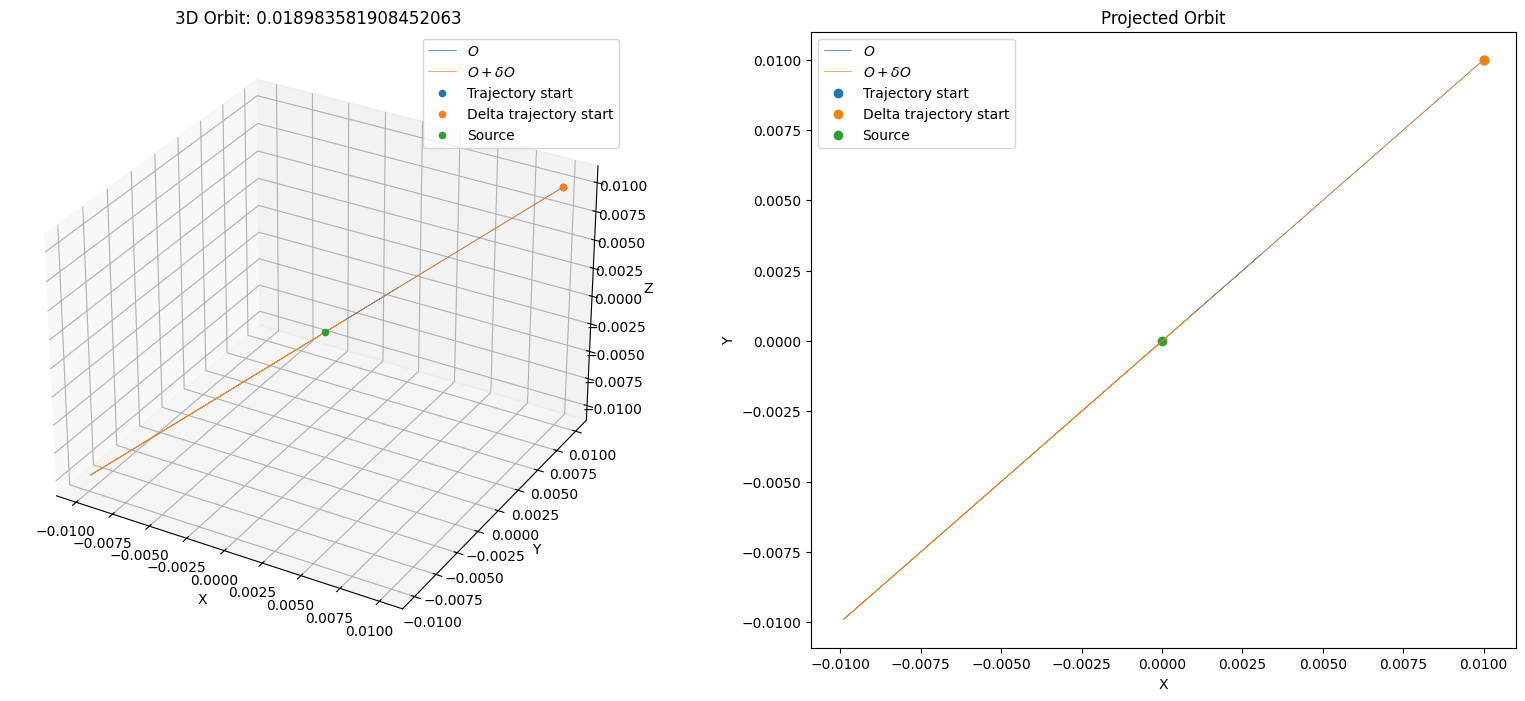

In [7]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(orbit.y[0], orbit.y[1], orbit.y[2], lw=0.5, label=r'$O$')
ax1.plot(orbit_delta.y[0], orbit_delta.y[1], orbit_delta.y[2], lw=0.5, label=r'$O+\delta O$')
ax1.scatter(init_params[0], init_params[1], init_params[2], label='Trajectory start')
ax1.scatter(init_params_delta[0], init_params_delta[1], init_params_delta[2], label='Delta trajectory start')
ax1.scatter(0, 0, 0, label='Source')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'3D Orbit: {fit_coeffs[0]}')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(orbit.y[0], orbit.y[1], lw=0.5, label=r'$O$')
ax2.plot(orbit_delta.y[0], orbit_delta.y[1], lw=0.5, label=r'$O+\delta O$')
ax2.scatter(init_params[0], init_params[1], label='Trajectory start')
ax2.scatter(init_params_delta[0], init_params_delta[1], label='Delta trajectory start')
ax2.scatter(0, 0, label='Source')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Projected Orbit')
ax2.legend()

In [8]:
init_params = [0.48813504, 2.15189366, 1.02763376, 0.1, 0, 0]
env.reset(init_params)
init_params, reward, _, _, info = env.step(np.zeros((6)), delta=1e-8)
orbit = solve_ivp(get_equations, t_span=(0, 1000), y0=init_params, t_eval=np.linspace(0, 100, 1000))
init_params_delta = init_params + np.random.normal(scale=1e-8, size=len(init_params))
orbit_delta = solve_ivp(get_equations, t_span=(0, 1000), y0=init_params_delta, t_eval=np.linspace(0, 100, 1000))
orbit_dists = np.linalg.norm(orbit.y - orbit_delta.y, axis=0)
log_orbit_dists = np.log(orbit_dists + 1e-8)
fit_coeffs = np.polyfit(orbit.t, log_orbit_dists, 1)

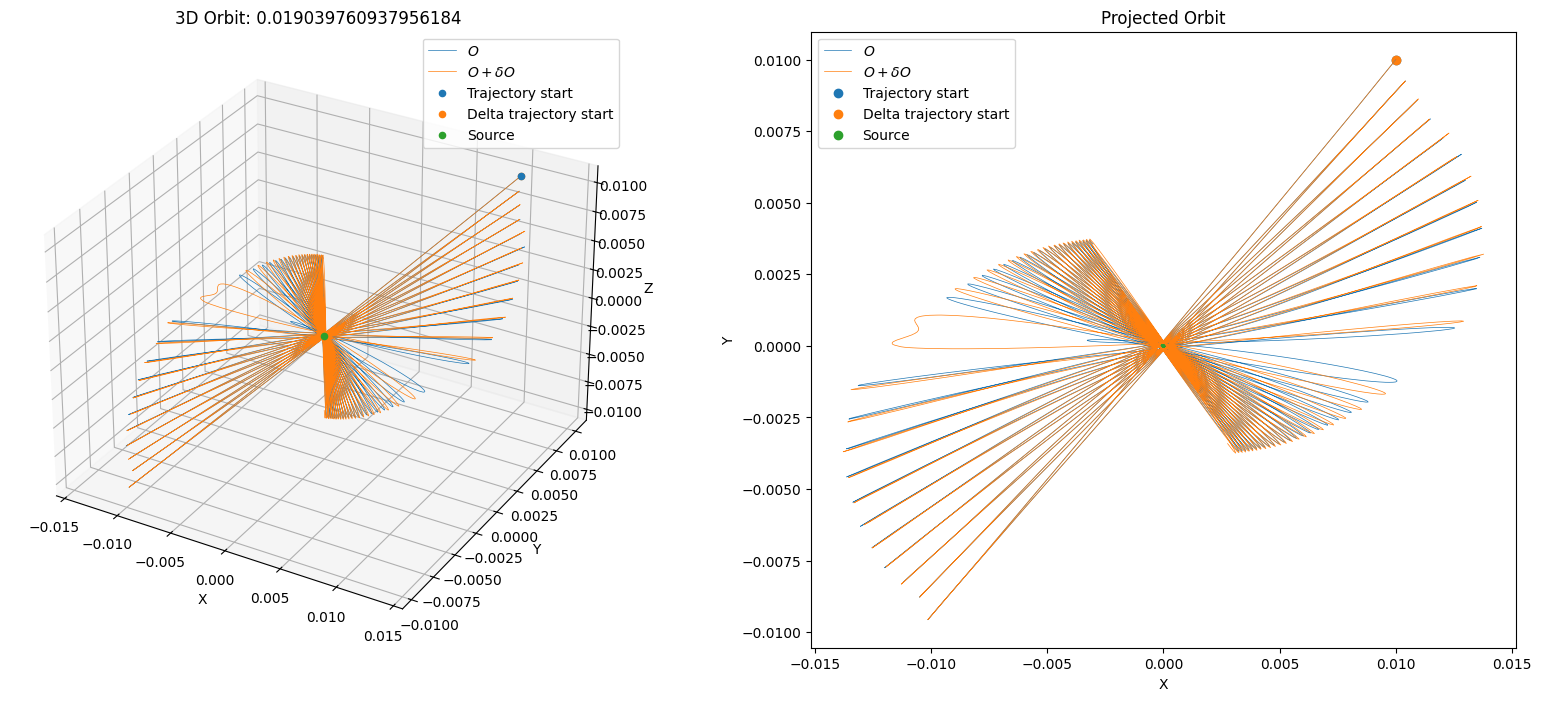

In [9]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(orbit.y[0], orbit.y[1], orbit.y[2], lw=0.5, label=r'$O$')
ax1.plot(orbit_delta.y[0], orbit_delta.y[1], orbit_delta.y[2], lw=0.5, label=r'$O+\delta O$')
ax1.scatter(init_params[0], init_params[1], init_params[2], label='Trajectory start')
ax1.scatter(init_params_delta[0], init_params_delta[1], init_params_delta[2], label='Delta trajectory start')
ax1.scatter(0, 0, 0, label='Source')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title(f'3D Orbit: {fit_coeffs[0]}')
ax1.legend()

ax2 = fig.add_subplot(122)
ax2.plot(orbit.y[0], orbit.y[1], lw=0.5, label=r'$O$')
ax2.plot(orbit_delta.y[0], orbit_delta.y[1], lw=0.5, label=r'$O+\delta O$')
ax2.scatter(init_params[0], init_params[1], label='Trajectory start')
ax2.scatter(init_params_delta[0], init_params_delta[1], label='Delta trajectory start')
ax2.scatter(0, 0, label='Source')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Projected Orbit')
ax2.legend()